# 2. Defining Success with Age and ETA

In this notebook, we'll programmatically generate some labels for our dataset. We will find a loose definition for a "successful prospect", which we'll then use in the next notebook to train a classifier.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from utils import *

import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

We'll load our dataset from the previous notebook and drop all rows missing an age value. We'll need the player's age to generate a label.

This leaves us with just under 8000 rows.

In [2]:
twtc = pd.read_csv('joined_stats.csv')
twtc = twtc.dropna(subset=['age'])

print(twtc.shape)
twtc.head()

(7967, 65)


,name,key_mlbam,key_fangraphs,key_bbref,key_bbref_minors,key_uuid,mlb_played_first,birthdate,debut_age,age,...,H,BB_pit,Age,3B,SO_pit,OBP,AVG,RBI,R,WHIP
0,**Luke Heimlich,-1,18360,NaN,NaN,NaN,NaN,NaN,NaN,22.3,...,82.0,0.0,—,0.0,0.0,0.345679,0.281787,47.0,41.0,0.000000
1,**Noah Song,679977,sa917943,NaN,NaN,NaN,NaN,NaN,NaN,22.0,...,75.0,0.0,—,3.0,0.0,0.349081,0.235849,33.0,47.0,0.880000
2,A.J. Alexy,669935,NaN,NaN,alexy-000aj-,c5bd95ff-593c-4875-b48e-012da0caca64,NaN,1998-04-21T00:00:00.000Z,NaN,19.7,...,0.0,3.0,0,0.0,12.0,0.000000,0.000000,0.0,0.0,1.460000
3,A.J. Alexy,669935,NaN,NaN,alexy-000aj-,c5bd95ff-593c-4875-b48e-012da0caca64,NaN,1998-04-21T00:00:00.000Z,NaN,18.7,...,0.0,3.0,0,0.0,12.0,0.000000,0.000000,0.0,0.0,1.460000
4,A.J. Cole,595918,11467,coleaj01,cole--001aj-,0596c185-ae62-436a-92b9-79b9a145d64d,2015.0,1992-01-05T00:00:00.000Z,23.0,22.0,...,0.0,15.0,—,0.0,61.0,0.000000,0.000000,0.0,0.0,1.323944


## Modeling ETA

To define a prospect as "successful", we'll use the idea of an "ETA". Scouting reports usually contain an estimate of how long it should take the player to reach the major leagues. We'll use this value to define a "successful" prospect as a prospect that _makes their MLB debut within the estimated timeframe of their ETA_.

The first challenge we face is that not every report contains an ETA. Luckily, we know that every report contains an age. So we can estimate ETA using a player's age, and apply these estimates to fill in the missing ETAs.

In [7]:
ages = twtc[['age', 'year', 'eta']].copy()

ages = ages.dropna()
ages = ages.astype(int, errors='ignore') # .apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=0)

#ages = ages.reset_index(drop=True)

ages['expected'] = (ages['age'] + (ages['eta'] - ages['year'])).astype(int)
# ages = onehot_encode_column(ages, 'primary_position')

ages[['age', 'eta', 'expected']].describe().round(3)

,age,eta,expected
count,7112.000,7112.000,7112.000
mean,20.882,2018.768,22.891
std,2.183,2.401,1.425
min,15.000,2013.000,18.000
25%,19.000,2017.000,22.000
50%,21.000,2019.000,23.000
75%,22.000,2020.000,24.000
max,31.000,2025.000,31.000


We can train a very simple linear regression with `sklearn` that predicts the age at which a player is expected to make their MLB debut, given their current age.

While this initially sounds quite naive, including more data (such as a player's position over certain grades) did not demonstrate any significant improvement. As such, we'll simply use age.

In [7]:
X = ages['age']
y = ages['expected']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

clf = LinearRegression().fit(train_X.values.reshape(-1, 1), train_y) # 
preds = clf.predict(test_X.values.reshape(-1, 1)) # 

print(f'ETA_[age] = ({clf.coef_[0].round(3)} * Age) + {clf.intercept_.round(3)}')
regression_results(test_y, preds)

ETA_[age] = (0.527 * Age) + 11.88
explained_variance:  0.6573
r2:  0.6562
MAE:  0.6486
MSE:  0.7005
RMSE:  0.837


As we can see, age alone does a pretty good job of predicting when a player should make their debut.

To make this slightly easier to understand, the chart below provides a visual demonstration. The `x` axis shows the current age of a player, and the `y` axis demonstrates the age at which a player is expected to make their debut.

The values generally check out, intuitively speaking. The slight upward curve makes sense - a 23-year old prospect shouldn't be given the same amount of time to debut as an 18 year old.

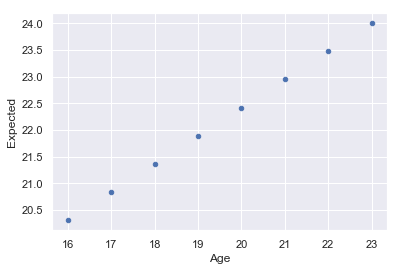

In [8]:
age = range(16, 24)
expected = clf.predict(np.array(age).reshape(-1, 1))

pd.DataFrame(list(zip(age, expected)), columns=['Age', 'Expected']).plot.scatter('Age', 'Expected')

## Labeling successes and busts

We can now generate our labels using this estimate. Again, players will be defined as _successful_ if they've made their MLB debut at or before the age at which they were expected to. Otherwise, they are defined as _unsuccessful_.

Readers might observe that this is a somewhat unfair definition of success; many players, like Jose Bautista and Josh Donaldson, took longer to make their debuts despite ultimately finding great success. Our argument is that while they were quite successful, their success is irrelevant to the team that drafted them. The Pittsburgh Pirates did not benefit from Bautista's success 10 years later, nor did the Chicago Cubs from Josh Donaldson's break-out 7 years later. We choose this "unfair" definition of success because it accurately captures the perspective of the team the player **currently** belongs to.

In [ ]:
twtc['eta_age'] = clf.predict(twtc[['age']].values.astype(int).reshape(-1, 1)) 
twtc['time_left'] = (twtc.eta_age - twtc.age)
twtc['cutoff'] = np.floor(twtc.year + twtc.time_left)

With some simple data manipulation, we can find the success cutoff for each prospect. This unfortunately limits our dataset, as we must exclude currently young players who are not yet expected to have made their debuts.

As we can see below, this leaves us with just under 6000 players who we can make a retrospective judgement for.

In [9]:
yr_ct = twtc.cutoff.value_counts().reset_index().rename(columns={'index': 'year'}).sort_values('year', ascending=False)
yr_ct = yr_ct[yr_ct.year < 2020]
pd.concat([yr_ct, yr_ct.cutoff.cumsum()], axis=1)

,year,cutoff,cutoff
0,2019.0,1417,1417
2,2018.0,1218,2635
3,2017.0,969,3604
4,2016.0,877,4481
5,2015.0,723,5204
7,2014.0,438,5642
9,2013.0,148,5790
10,2012.0,32,5822
12,2011.0,2,5824


Finally, we apply our labeling function. If a player has not yet debuted or debuted after their cutoff, they are _unsuccessful_. Otherwise, they are _successful_. 

In [10]:
def label_fn(row):
    debut = row['mlb_played_first']
    cutoff = row['cutoff']
    
    if pd.isnull(debut):
        return 0
    if debut > cutoff:
        return 0
    return 1
        
twtc = twtc[twtc.cutoff < 2020]
twtc['label'] = twtc.apply(label_fn, axis=1)
twtc.head()

,name,key_mlbam,key_fangraphs,key_bbref,key_bbref_minors,key_uuid,mlb_played_first,birthdate,debut_age,age,...,OPS,AB,SV,BB,W,SLG,eta_age,time_left,cutoff,label
0,**Luke Heimlich,-1,18360,NaN,NaN,NaN,NaN,NaN,NaN,22.3,...,0.809597,291.0,0.0,26.0,0.0,0.463918,23.475461,1.175461,2019.0,0
3,A.J. Alexy,669935,NaN,NaN,alexy-000aj-,c5bd95ff-593c-4875-b48e-012da0caca64,NaN,1998-04-21T00:00:00.000Z,NaN,18.7,...,0.000000,0.0,0.0,0.0,1.0,0.000000,21.367183,2.667183,2019.0,0
4,A.J. Cole,595918,11467,coleaj01,cole--001aj-,0596c185-ae62-436a-92b9-79b9a145d64d,2015.0,1992-01-05T00:00:00.000Z,23.0,22.0,...,0.000000,8.0,0.0,0.0,6.0,0.000000,23.475461,1.475461,2015.0,1
5,A.J. Cole,595918,11467,coleaj01,cole--001aj-,0596c185-ae62-436a-92b9-79b9a145d64d,2015.0,1992-01-05T00:00:00.000Z,23.0,24.0,...,0.333333,4.0,0.0,2.0,8.0,0.000000,24.529600,0.529600,2016.0,1
6,A.J. Cole,595918,11467,coleaj01,cole--001aj-,0596c185-ae62-436a-92b9-79b9a145d64d,2015.0,1992-01-05T00:00:00.000Z,23.0,21.0,...,0.000000,5.0,0.0,0.0,6.0,0.000000,22.948392,1.948392,2014.0,0


In [ ]:
The distribution of the labels make intuitive sense. 

In [11]:
twtc.label.value_counts()

0    4672
1    1152
Name: label, dtype: int64

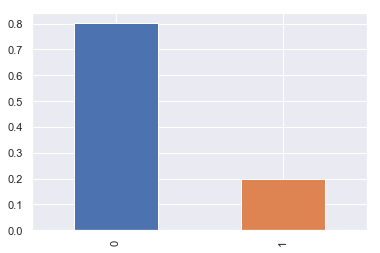

In [12]:
(twtc.label.value_counts() / len(twtc)).plot.bar()

In [13]:
twtc.to_csv('labelled.csv', index=False)